<a href="https://colab.research.google.com/github/netomap/Deteccao_Objetos_com_TF/blob/second/Teste2_Detector_Objetos_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 460kB 43.2MB/s 
     |████████████████████████████████| 3.0MB 36.0MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 1936, done.
remote: Counting objects: 100% (1936/1936), done.
remote: Compressing objects: 100% (1683/1683), done.
remote: Total 1936 (delta 451), reused 804 (delta 234), pack-reused 0
Receiving objects: 100% (1936/1936), 51.37 MiB | 14.94 MiB/s, done.
Resolving deltas: 100% (451/451), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1549265 sha256=390c2bb71ca11b805bd23cddd181addd04068b874dd0ca4baf08492fb4ead6eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-nxr346ag/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.8.1-cp36-none-any.whl size=43164 sha256=8b5b2db612dcb5220341d4f8e322e4486b5ce0b3ed6f49a533dadf8ab48958d3
  Stored in directory: /root/.cache/pip/wheels/5c/04/3c/ffe3561c960133e747de503dea3e3facef2dea533bc92cb21a
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=f7949db4be0e89021a056dafdb71f1d197d4c3e2153a9084768fa110c16f4598
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78532 sha256=f253edd76821f57a53564afe05d4c0b0625afbfd3919c390082b7

ERROR: pydrive 1.3.1 has requirement oauth2client>=4.0.0, but you'll have oauth2client 3.0.0 which is incompatible.
ERROR: multiprocess 0.70.10 has requirement dill>=0.3.2, but you'll have dill 0.3.1.1 which is incompatible.


In [4]:
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

Funções Úteis

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.4)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

Images e dados das fotos de kiwi

In [6]:
df = pd.read_csv('annotations.csv', header=None)
df.head()
data_annotations = df.values

In [7]:
df.head()

,0,1,2,3,4,5,6,7
0,images/fruits (1).jpg,630,419,54,74,354,359,kiwi
1,images/fruits (10).jpg,290,174,158,99,256,172,kiwi
2,images/fruits (11).jpg,500,500,191,218,414,442,kiwi
3,images/fruits (12).jpg,750,350,301,178,501,347,kiwi
4,images/fruits (13).jpg,961,531,478,272,768,433,kiwi


In [8]:
# levando os dados das imagens para um vetor train_images_np
# além de preparação dos vetores bouding boxes, que possem as anotações dos objetos nas images.
train_images_np = []
gt_boxes = []

for linha in data_annotations:
  train_images_np.append(load_image_into_numpy_array(linha[0]))
  w, h, x0, y0, x1, y1, classe = linha[1], linha[2], linha[3], linha[4], linha[5], linha[6], linha[7]
  gt_boxes.append(np.array([[y0/h, x0/w, y1/h, x1/w]], dtype=np.float32))

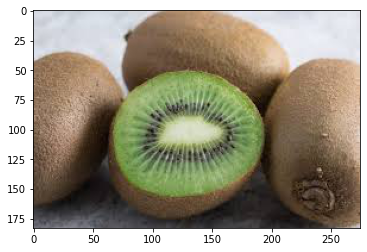

In [10]:
# teste simples para verificar o vetor novo
img = train_images_np[10]
plt.imshow(img)
plt.show()

In [13]:
gt_boxes

[array([[0.17661098, 0.08571429, 0.8568019 , 0.5619048 ]], dtype=float32),
 array([[0.5689655, 0.5448276, 0.9885057, 0.8827586]], dtype=float32),
 array([[0.436, 0.382, 0.884, 0.828]], dtype=float32),
 array([[0.50857145, 0.40133333, 0.99142855, 0.668     ]], dtype=float32),
 array([[0.51224107, 0.49739856, 0.81544256, 0.7991675 ]], dtype=float32),
 array([[0.5681818, 0.6484375, 1.       , 0.9238281]], dtype=float32),
 array([[0.08577878, 0.46052632, 0.51241535, 0.7486842 ]], dtype=float32),
 array([[0.31034482, 0.535     , 0.4857571 , 0.67      ]], dtype=float32),
 array([[0.79555553, 0.5477778 , 0.9288889 , 0.62333333]], dtype=float32),
 array([[0.31111112, 0.16333333, 0.97555554, 0.6816667 ]], dtype=float32),
 array([[0.27322406, 0.22909091, 0.95628417, 0.7054545 ]], dtype=float32),
 array([[0.2767857 , 0.29166666, 0.47916666, 0.5595238 ]], dtype=float32),
 array([[0.3223301 , 0.3106796 , 0.9669903 , 0.97475725]], dtype=float32),
 array([[0.4321608 , 0.01581028, 0.919598  , 0.434782

In [14]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
duck_class_id = 1
num_classes = 1

category_index = {duck_class_id: {'id': duck_class_id, 'name': 'kiwi'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


In [15]:
print ('tensor shape: {}'.format(train_image_tensors[0].shape))
print ('gt_box_tensors shape: {}'.format(gt_box_tensors[0].shape))
print ('zero_indexed_groundtruth_classes shape: {}'.format(zero_indexed_groundtruth_classes[0].shape))
print ('gt_classes_one_hot_tensors shape: {}'.format(gt_classes_one_hot_tensors[0].shape))

tensor shape: (1, 419, 630, 3)
gt_box_tensors shape: (1, 4)
zero_indexed_groundtruth_classes shape: ()
gt_classes_one_hot_tensors shape: (1, 1)


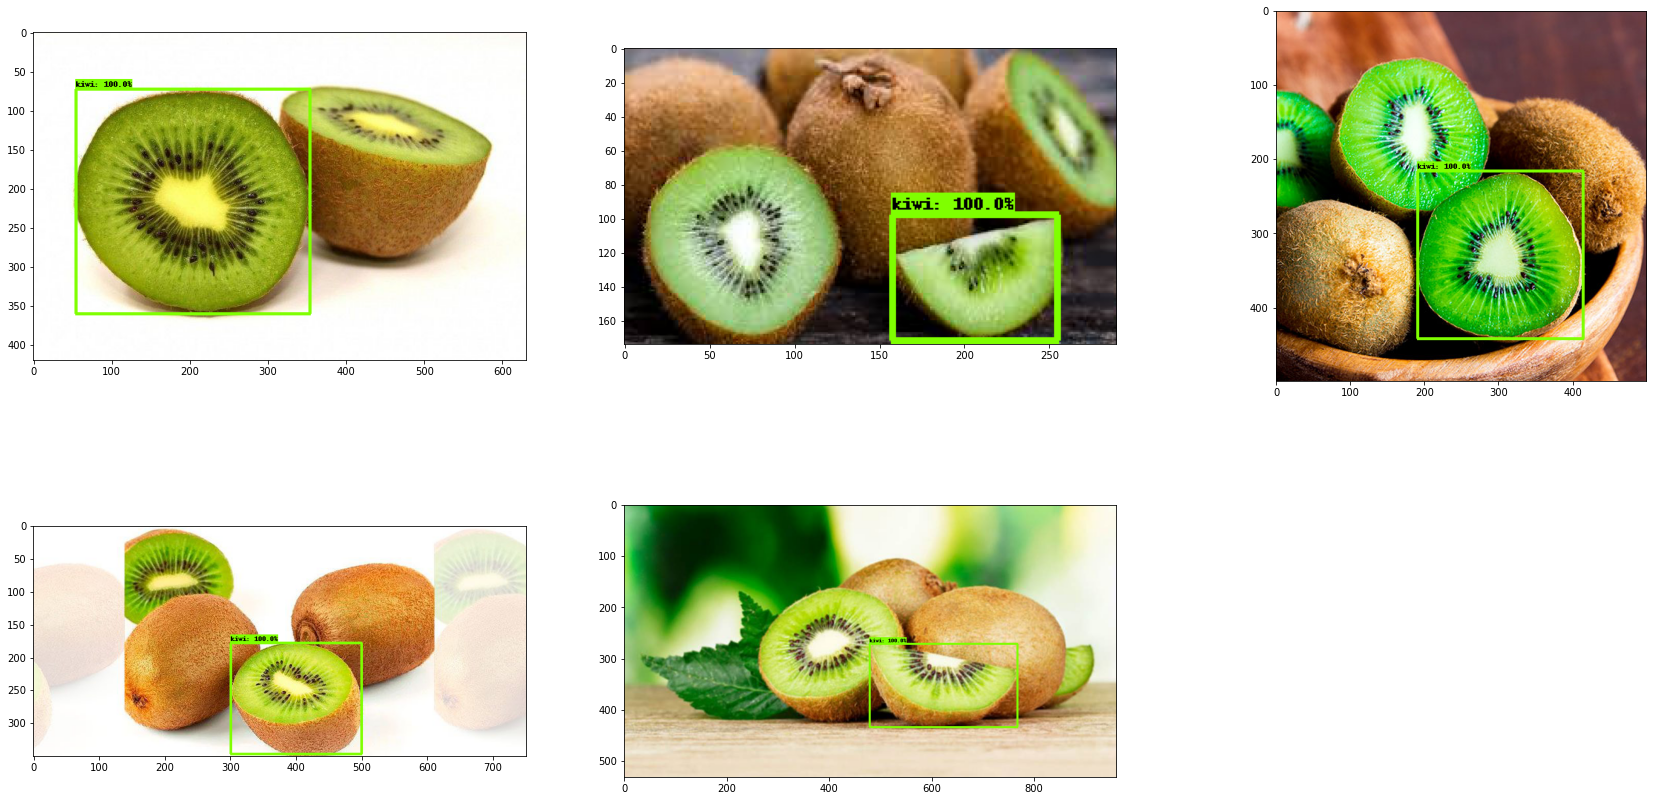

In [16]:
dummy_scores = np.array([1.], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

In [17]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-08-09 17:11:44--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.204.128, 2404:6800:4008:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.204.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  82.5MB/s    in 2.8s    

2020-08-09 17:11:48 (82.5 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [18]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [19]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.1443963
batch 10 of 100, loss=1.0122628
batch 20 of 100, loss=1.1430764
batch 30 of 100, loss=0.35605264
batch 40 of 100, loss=0.26321203
batch 50 of 100, loss=0.055294294
batch 60 of 100, loss=0.11792204
batch 70 of 100, loss=0.14602807
batch 80 of 100, loss=0.064187914
batch 90 of 100, loss=0.06621177
Done fine-tuning!


In [20]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

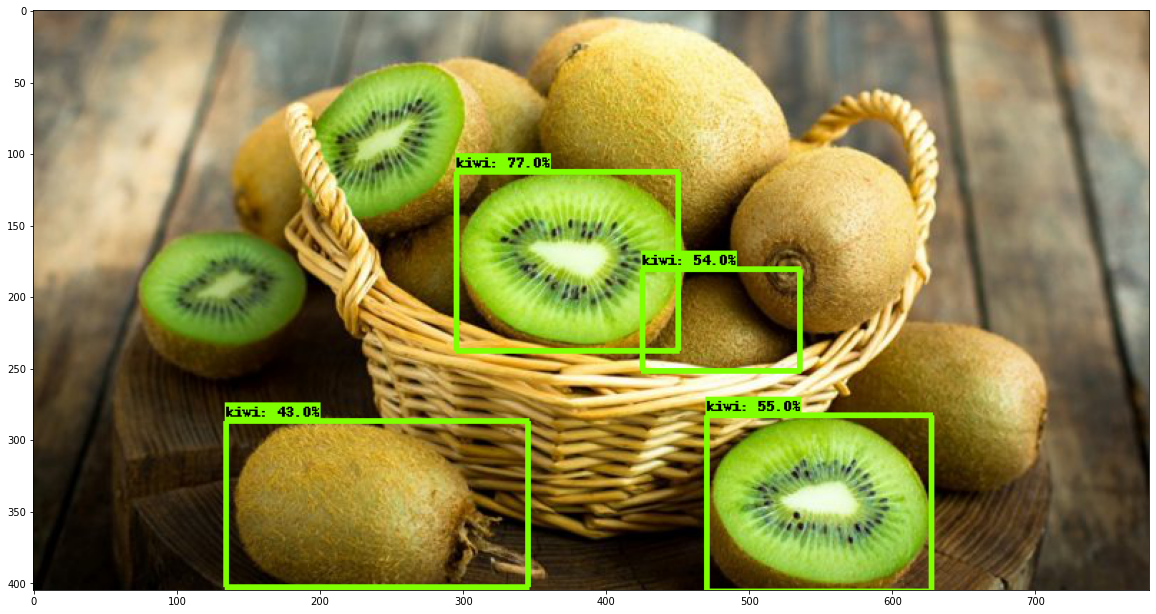

In [24]:
test_image_np = np.expand_dims(load_image_into_numpy_array('/content/images/test/test (4).jpg'), axis=0)

input_tensor = tf.convert_to_tensor(test_image_np, dtype=tf.float32)
detections = detect(input_tensor)

plt.figure(figsize=(20,20))
plot_detections(
    test_image_np[0],
    detections['detection_boxes'][0].numpy(),
    detections['detection_classes'][0].numpy().astype(np.uint32)
    + 1,
    detections['detection_scores'][0].numpy(),
    category_index)

In [ ]:
detections_boxes = detections['detection_boxes'][0].numpy()
detections_scores = detections['detection_scores'][0].numpy()
detections_classes = detections['detection_classes'][0].numpy()

In [ ]:
print ('detections_boxes shape: {}'.format(detections_boxes.shape))
print ('detections_scores shape: {}'.format(detections_scores.shape))
print ('detections_classes shape: {}'.format(detections_classes.shape))

detections_boxes shape: (100, 4)
detections_scores shape: (100,)
detections_classes shape: (100,)
